### Load and Analyze Grant Data
The `download_data.py` script has already downloaded, extracted, and processed the raw XML data into a clean CSV file located at `data/parsed_grants.csv`. This notebook will now focus on loading this pre-processed data and performing an in-depth analysis of the grant information.

In [3]:
import pandas as pd

# Load the parsed data from the CSV file
grants_df = pd.read_csv('data/parsed_grants.csv')

# Display basic information and the first few rows to verify the data
print("Successfully loaded 'data/parsed_grants.csv'")
print(f"The dataset contains {grants_df.shape[0]} rows and {grants_df.shape[1]} columns.")
print("\nFirst 5 rows of the dataset:")
print(grants_df.head())

# Display summary statistics for numerical columns
print("\nSummary statistics for numerical columns:")
print(grants_df.describe())

# Check for missing values in each column
print("\nMissing values per column:")
print(grants_df.isnull().sum())

Successfully loaded 'data/parsed_grants.csv'
The dataset contains 327376 rows and 11 columns.

First 5 rows of the dataset:
    FilerEIN                    FilerName  ReturnType TaxPeriodEnd  \
0  208578192           OAKLAWN FOUNDATION         990   2024-06-30   
1  208578192           OAKLAWN FOUNDATION         990   2024-06-30   
2  570314406  North Greenville University         990   2024-05-31   
3  570314406  North Greenville University         990   2024-05-31   
4   43102943     NEW AMERICAN ASSOCIATION         990   2024-06-30   

   TotalGrantsPaid                  RecipientName  RecipientCity  \
0                0  ARKANSAS COMMUNITY FOUNDATION            NaN   
1                0        OAKLAWN CENTER ON AGING            NaN   
2                0      First Presbyterian Church            NaN   
3                0     Tigerville Fire Department            NaN   
4                0   CONGOLESE DEVELOPMENT CENTER            NaN   

   RecipientState  RecipientZIP  GrantAmount  

In [4]:
# Define keywords for a broad search related to kidney health
keywords = [
    "kidney", "organ donation", "organ", "transplant", "dialysis",
    "smoking cessation", "tobacco", "weight loss", "obesity",
    "fitness", "lifestyle change", "behavior change", "public health",
    "preventive health", "underserved", "health equity", "minority health", "nephrology"
]
    
# Create a regex pattern to search for any of the keywords, case-insensitively
regex_pattern = '|'.join(keywords)

# Filter the DataFrame for grants where 'GrantPurpose' contains any of the keywords.
# The `na=False` argument ensures that NaN values in 'GrantPurpose' are treated as not matching.
kidney_related_grants_df = grants_df[grants_df['GrantPurpose'].str.contains(regex_pattern, case=False, na=False)].copy()

# Display the number of grants found and show a sample of the results
print(f"Found {len(kidney_related_grants_df)} grants related to the specified keywords.")
print("\nFirst 10 rows of the filtered dataset:")
print(kidney_related_grants_df.head(10))

# Load the filer data, specifying dtype for 'EIN' to ensure consistency
filer_df = pd.read_csv('data/parsed_filer_data.csv', dtype={'EIN': str})

# Ensure 'FilerEIN' in grants_df is also a string to prevent merge issues
kidney_related_grants_df['FilerEIN'] = kidney_related_grants_df['FilerEIN'].astype(str)

# Merge the kidney-related grants with the filer data
# This join adds detailed filer information to each grant record
merged_df = pd.merge(kidney_related_grants_df, filer_df, left_on='FilerEIN', right_on='EIN', how='left')

# Calculate the average grant amount for each filer and add it as a new column
# The 'transform' function is used to broadcast the mean value back to the original DataFrame shape
merged_df['AverageGrantAmount'] = merged_df.groupby('FilerName')['GrantAmount'].transform('mean')

# Sort the DataFrame first by the average grant amount in descending order,
# then by the individual grant amount in descending order for filers with the same average
final_ranked_df = merged_df.sort_values(by=['AverageGrantAmount', 'GrantAmount'], ascending=[False, False])

# Display the top 20 grants from the ranked list, showing key information
print("\nTop 20 Kidney-Related Grants, Ranked by Filer's Average Grant Amount:")
print(final_ranked_df[[
    'FilerName', 'GrantAmount', 'AverageGrantAmount', 
    'RecipientName', 'GrantPurpose', 'Organization501cType', 'TotalRevenue'
]].head(20))

# Save the final ranked DataFrame to a new CSV file for further analysis or reporting
final_ranked_df.to_csv('data/kidney_related_grants_ranked.csv', index=False)
print("\nSaved the ranked kidney-related grants to 'data/kidney_related_grants_ranked.csv'")

Found 3649 grants related to the specified keywords.

First 10 rows of the filtered dataset:
      FilerEIN             FilerName  ReturnType TaxPeriodEnd  \
11   870800705  Fuse Innovation Fund         990   2024-06-30   
12   870800705  Fuse Innovation Fund         990   2024-06-30   
13   870800705  Fuse Innovation Fund         990   2024-06-30   
14   870800705  Fuse Innovation Fund         990   2024-06-30   
15   870800705  Fuse Innovation Fund         990   2024-06-30   
16   870800705  Fuse Innovation Fund         990   2024-06-30   
255  882722663      AGE WELL AT HOME         990   2024-12-31   
256  882722663      AGE WELL AT HOME         990   2024-12-31   
257  882722663      AGE WELL AT HOME         990   2024-12-31   
381  741159753     BAYLOR UNIVERSITY         990   2024-05-31   

     TotalGrantsPaid                               RecipientName  \
11                 0                      PA Alliance Foundation   
12                 0                           Justice 

Generating embeddings for 1000 grant purposes...
Successfully generated 1000 embeddings.

--- Cluster 1 ---
- For the general support of your organization in fulfilling its charitable objectives, in memory of Mary Joy Hutchinson Crosetto

--- Cluster 2 ---
- TO FURTHER THE EXEMPT PURPOSE OF THE ORGANIZATION
- TO FURTHER THE EXEMPT PURPOSE OF THE ORGANIZATION
- TO FURTHER THE EXEMPT PURPOSE OF THE ORGANIZATION.
- TO FURTHER THE EXEMPT PURPOSE OF THE ORGANIZATION
- UNDESIGNATED AND PROGRAM RESTRICTED FUNDS TO FURTHER ORGANIZATION'S EXEMPT PURPOSE

--- Cluster 3 ---
- Support Organization
- ORGANIZATION
- GENERAL SUPPORT OF THE ORGANIZATION.
- ORGANIZATION
- TO AID THE FUNCTIONS OF THE ORGANIZATION

--- Cluster 4 ---
- RUN PROGRAMS FOR SENIOR CITIZENS IN THE ORGANIZATION'S SERVICE AREA.
- ORGANIZATION SUPPORT GRANT
- Aid organization distributes aid
- REGRANT TO PARTNER ORGANIZATION
- GRANT TO ESTABLISH AND FUND THE FUTURE OF LIFE FOUNDATION, A RELATED ORGANIZATION TO FLI

--- Cluster 5 -

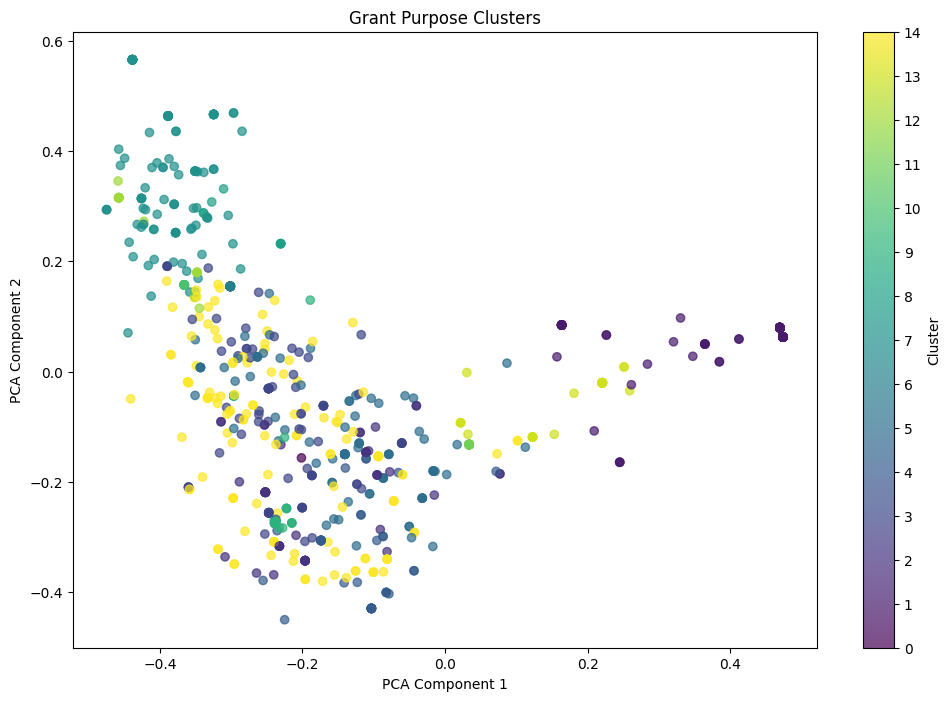

In [5]:
# Ensure you have an OpenAI API key set as an environment variable
# For example: export OPENAI_API_KEY='your_api_key_here'
import os
import openai
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Set the OpenAI API key
if "OPENAI_API_KEY" not in os.environ:
    print("Please set the OPENAI_API_KEY environment variable in a .env file to run this cell.")
else:
    openai.api_key = os.environ.get("OPENAI_API_KEY")

    # Get embeddings for each grant purpose
    # Using a sample to manage costs and API rate limits during development
    sample_df = final_ranked_df.sample(n=min(1000, len(final_ranked_df)), random_state=42)
    grant_purposes = sample_df['GrantPurpose'].dropna().tolist()

    print(f"Generating embeddings for {len(grant_purposes)} grant purposes...")

    def get_embedding(text, model="text-embedding-3-small"):
        text = str(text).replace("\n", " ")
        try:
            return openai.embeddings.create(input=[text], model=model).data[0].embedding
        except Exception as e:
            print(f"Could not get embedding for text: {text[:50]}... Error: {e}")
            return None

    embeddings = [get_embedding(purpose) for purpose in grant_purposes]
    valid_embeddings = [emb for emb in embeddings if emb is not None]
    valid_purposes = [purpose for emb, purpose in zip(embeddings, grant_purposes) if emb is not None]

    if valid_embeddings:
        print(f"Successfully generated {len(valid_embeddings)} embeddings.")
        # Cluster the embeddings
        num_clusters = 15 # You can adjust this number to find the optimal number of topics
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto').fit(valid_embeddings)
        sample_df.loc[sample_df['GrantPurpose'].notna(), 'Cluster'] = kmeans.labels_

        # Analyze and print top terms for each cluster
        for i in range(num_clusters):
            cluster_purposes = np.array(valid_purposes)[kmeans.labels_ == i]
            print(f"\n--- Cluster {i+1} ---")
            # Print up to 5 purposes from each cluster
            for purpose in cluster_purposes[:5]:
                print(f"- {purpose}")

        # Visualize the clusters
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(valid_embeddings)

        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.7)
        plt.title('Grant Purpose Clusters')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.colorbar(scatter, ticks=range(num_clusters), label='Cluster')
        plt.show()